# 16장. 순환 신경망으로 시퀀스 데이터 모델링하기

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,scipy,pyprind,tensorflow

last updated: 2019-02-26 

CPython 3.6.7
IPython 7.1.1

numpy 1.15.4
scipy 1.2.0
pyprind 2.11.2
tensorflow 1.12.0


In [2]:
import gzip


with gzip.open('movie_data.csv.gz') as f_in, open('movie_data.csv', 'wb') as f_out:
    f_out.writelines(f_in)

# 텐서플로의 케라스 API로 시퀀스 모델링을 위한 다층 RNN 구현하기

## 첫 번째 프로젝트 - 다층 RNN으로 IMDb 영화 리뷰의 감성 분석 수행하기

### 데이터 준비

In [3]:
import pyprind
import pandas as pd
from string import punctuation
import re
import numpy as np


df = pd.read_csv('movie_data.csv', encoding='utf-8')
print(df.head(3))

                                              review  sentiment
0  In 1974, the teenager Martha Moxley (Maggie Gr...          1
1  OK... so... I really like Kris Kristofferson a...          0
2  ***SPOILER*** Do not read this, if you think a...          0


In [4]:
## 데이터 전처리:
## 단어를 나누고 등장 횟수를 카운트합니다.

from collections import Counter


counts = Counter()
pbar = pyprind.ProgBar(len(df['review']),
                       title='단어의 등장 횟수를 카운트합니다.')
for i,review in enumerate(df['review']):
    text = ''.join([c if c not in punctuation else ' '+c+' ' \
                    for c in review]).lower()
    df.loc[i,'review'] = text
    pbar.update()
    counts.update(text.split())

단어의 등장 횟수를 카운트합니다.
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:05:11


In [5]:
## 고유한 각 단어를 정수로 매핑하는
## 딕셔너리를 만듭니다.

word_counts = sorted(counts, key=counts.get, reverse=True)
print(word_counts[:5])
word_to_int = {word: ii for ii, word in enumerate(word_counts, 1)}


mapped_reviews = []
pbar = pyprind.ProgBar(len(df['review']),
                       title='리뷰를 정수로 매핑합니다.')
for review in df['review']:
    mapped_reviews.append([word_to_int[word] for word in review.split()])
    pbar.update()

리뷰를 정수로 매핑합니다.


['the', '.', ',', 'and', 'a']


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


In [6]:
## 동일 길이의 시퀀스를 만듭니다.
## 시퀀스 길이가 200보다 작으면 왼쪽에 0이 패딩됩니다.
## 시퀀스 길이가 200보다 크면 마지막 200개 원소만 사용합니다.

sequence_length = 200  ## (RNN 공식에 있는 T 값 입니다)
sequences = np.zeros((len(mapped_reviews), sequence_length), dtype=int)
for i, row in enumerate(mapped_reviews):
    review_arr = np.array(row)
    sequences[i, -len(row):] = review_arr[-sequence_length:]

X_train = sequences[:37500, :]
y_train = df.loc[:37499, 'sentiment'].values
X_test = sequences[37500:, :]
y_test = df.loc[37500:, 'sentiment'].values

In [7]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(37500, 200) (37500,) (12500, 200) (12500,)


In [8]:
n_words = len(word_to_int) + 1
print(n_words)

102967


### 임베딩

In [9]:
from tensorflow.keras import models, layers

In [10]:
model = models.Sequential()

In [11]:
model.add(layers.Embedding(n_words, 200, 
                           embeddings_regularizer='l2'))

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         20593400  
Total params: 20,593,400
Trainable params: 20,593,400
Non-trainable params: 0
_________________________________________________________________


### RNN 모델 만들기

In [13]:
model.add(layers.LSTM(16))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         20593400  
_________________________________________________________________
lstm (LSTM)                  (None, 16)                13888     
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 20,607,305
Trainable params: 20,607,305
Non-trainable params: 0
_________________________________________________________________


### 감성 분석 RNN 모델 훈련하기

In [15]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [16]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

callback_list = [ModelCheckpoint(filepath='sentiment_rnn_checkpoint.h5',
                                 monitor='val_loss', 
                                 save_best_only=True), 
                 TensorBoard(log_dir="sentiment_rnn_logs/{}".format(
                     time.asctime()))]

In [17]:
history = model.fit(X_train, y_train, 
                    batch_size=64, epochs=10, 
                    validation_split=0.3, callbacks=callback_list)

Train on 26250 samples, validate on 11250 samples
Epoch 1/10
26250/26250 [==============================] - 96s 4ms/step - loss: 6.7851 - acc: 0.6952 - val_loss: 0.7474 - val_acc: 0.7560
Epoch 2/10
26250/26250 [==============================] - 95s 4ms/step - loss: 0.6268 - acc: 0.8255 - val_loss: 0.5755 - val_acc: 0.8452
Epoch 3/10
26250/26250 [==============================] - 95s 4ms/step - loss: 0.5411 - acc: 0.8480 - val_loss: 0.5019 - val_acc: 0.8612
Epoch 4/10
26250/26250 [==============================] - 95s 4ms/step - loss: 0.4915 - acc: 0.8675 - val_loss: 0.4895 - val_acc: 0.8624
Epoch 5/10
26250/26250 [==============================] - 94s 4ms/step - loss: 0.4662 - acc: 0.8747 - val_loss: 0.5078 - val_acc: 0.8609
Epoch 6/10
26250/26250 [==============================] - 95s 4ms/step - loss: 0.4436 - acc: 0.8826 - val_loss: 0.4592 - val_acc: 0.8751
Epoch 7/10
26250/26250 [==============================] - 94s 4ms/step - loss: 0.4293 - acc: 0.8929 - val_loss: 0.5039 - val_acc

In [18]:
import matplotlib.pyplot as plt

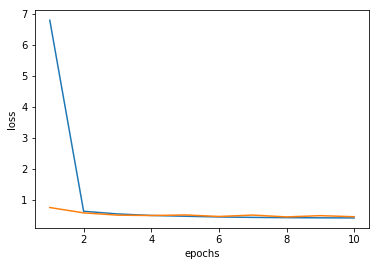

In [19]:
epochs = np.arange(1, 11)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

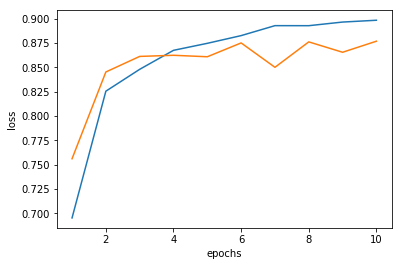

In [20]:
epochs = np.arange(1, 11)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### 감성 분석 RNN 모델 평가하기

In [21]:
model.load_weights('sentiment_rnn_checkpoint.h5')
model.evaluate(X_test, y_test)

12500/12500 [==============================] - 18s 1ms/step


[0.4483366913795471, 0.875199999961853]

In [22]:
model.predict_proba(X_test[:10])

array([[0.00712916],
       [0.01935937],
       [0.0012364 ],
       [0.9547964 ],
       [0.9866888 ],
       [0.9777349 ],
       [0.05132445],
       [0.83341104],
       [0.00486496],
       [0.82214034]], dtype=float32)

In [23]:
model.predict_classes(X_test[:10])

array([[0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1]], dtype=int32)

## 두 번째 프로젝트 – 텐서플로로 글자 단위 언어 모델 구현하기

### 데이터 전처리

In [24]:
import numpy as np


## 텍스트를 읽고 처리합니다.
with open('pg2265.txt', 'r', encoding='utf-8') as f: 
    text=f.read()

text = text[15858:]
chars = set(text)
char2int = {ch:i for i,ch in enumerate(chars)}
int2char = dict(enumerate(chars))
text_ints = np.array([char2int[ch] for ch in text], 
                     dtype=np.int32)

In [25]:
len(text)

162849

In [50]:
len(chars)

65

In [26]:
def reshape_data(sequence, batch_size, num_steps):
    mini_batch_length = batch_size * num_steps
    num_batches = int(len(sequence) / mini_batch_length)
    if num_batches*mini_batch_length + 1 > len(sequence):
        num_batches = num_batches - 1
    ## 전체 배치에 포함되지 않는 시퀀스 끝부분은 삭제합니다.
    x = sequence[0 : num_batches*mini_batch_length]
    y = sequence[1 : num_batches*mini_batch_length + 1]
    ## x와 y를 시퀀스 배치의 리스트로 나눕니다.
    x_batch_splits = np.split(x, batch_size)
    y_batch_splits = np.split(y, batch_size)
    ## 합쳐진 배치 크기는
    ## batch_size x mini_batch_length가 됩니다.
    x = np.stack(x_batch_splits)
    y = np.stack(y_batch_splits)
    
    return x, y

In [30]:
## 테스트
train_x, train_y = reshape_data(text_ints, 64, 10)
print(train_x.shape)
print(train_x[0, :10])
print(train_y[0, :10])
print(''.join(int2char[i] for i in train_x[0, :10]))
print(''.join(int2char[i] for i in train_y[0, :10]))

(64, 2540)
[50 24 49  7 50 11 15 25 49  2]
[24 49  7 50 11 15 25 49  2 13]
The Traged
he Tragedi


In [31]:
def create_batch_generator(data_x, data_y, num_steps):
    batch_size, tot_batch_length = data_x.shape[0:2]   
    num_batches = int(tot_batch_length/num_steps)
    for b in range(num_batches):
        yield (data_x[:, b*num_steps: (b+1)*num_steps], 
               data_y[:, b*num_steps: (b+1)*num_steps])

In [33]:
bgen = create_batch_generator(train_x[:,:100], train_y[:,:100], 15)
for x, y in bgen:
    print(x.shape, y.shape, end='  ')
    print(''.join(int2char[i] for i in x[0,:]).replace('\n', '*'), '    ',
          ''.join(int2char[i] for i in y[0,:]).replace('\n', '*'))

(64, 15) (64, 15)  The Tragedie of      he Tragedie of 
(64, 15) (64, 15)   Hamlet**Actus       Hamlet**Actus P
(64, 15) (64, 15)  Primus. Scoena       rimus. Scoena P
(64, 15) (64, 15)  Prima.**Enter B      rima.**Enter Ba
(64, 15) (64, 15)  arnardo and Fra      rnardo and Fran
(64, 15) (64, 15)  ncisco two Cent      cisco two Centi


In [34]:
batch_size = 64
num_steps = 100 
train_x, train_y = reshape_data(text_ints, batch_size, num_steps)
print(train_x.shape, train_y.shape)

(64, 2500) (64, 2500)


In [35]:
from tensorflow.keras.utils import to_categorical

train_encoded_x = to_categorical(train_x)
train_encoded_y = to_categorical(train_y)
print(train_encoded_x.shape, train_encoded_y.shape)

(64, 2500, 65) (64, 2500, 65)


In [49]:
print(np.max(train_x), np.max(train_y))

64 64


### 글자 단위 RNN 모델 만들기

In [36]:
char_model = models.Sequential()

In [38]:
num_classes = len(chars)

char_model.add(layers.LSTM(128, input_shape=(None, num_classes), 
                           return_sequences=True))
char_model.add(layers.TimeDistributed(layers.Dense(num_classes, 
                                                   activation='softmax')))

In [39]:
char_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 128)         99328     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 65)          8385      
Total params: 107,713
Trainable params: 107,713
Non-trainable params: 0
_________________________________________________________________


### 글자 단위 RNN 모델 훈련하기

In [43]:
from tensorflow.keras.optimizers import Adam

adam = Adam(clipnorm=5.0)

In [44]:
char_model.compile(loss='categorical_crossentropy', optimizer=adam)

In [ ]:
callback_list = [ModelCheckpoint(filepath='char_rnn_checkpoint.h5')] 

In [45]:
for i in range(500):
    bgen = create_batch_generator(train_encoded_x, 
                                  train_encoded_y, num_steps)
    char_model.fit_generator(bgen, steps_per_epoch=5, epochs=5, 
                             callbacks=callback_list, verbose=0)

### 글자 단위 RNN 모델로 텍스트 생성하기

In [46]:
np.random.seed(42)

def get_top_char(probas, char_size, top_n=5):
    p = np.squeeze(probas)
    p[np.argsort(p)[:-top_n]] = 0.0
    p = p / np.sum(p)
    ch_id = np.random.choice(char_size, 1, p=p)[0]
    return ch_id

In [47]:
seed_text = "The "
for ch in seed_text:
    num = [char2int[ch]]
    onehot = to_categorical(num, num_classes=65)
    onehot = np.expand_dims(onehot, axis=0)
    probas = char_model.predict(onehot)
num = get_top_char(probas, len(chars))
seed_text += int2char[num]

In [48]:
for i in range(500):
    onehot = to_categorical([num], num_classes=65)
    onehot = np.expand_dims(onehot, axis=0)
    probas = char_model.predict(onehot)
    num = get_top_char(probas, len(chars))
    seed_text += int2char[num]
print(seed_text)

The ayond  wat we   in ind ant andis wes  th are ts asese, wis iore indo we  thes isthar inger thes and  ts wint  iseshes wator into and its tsend io th it  ay thin the ts  at ashin wio we tongs wer ine,
As wardis athind thero as witherondordisene  wite, ats ayondit ayothastouerountour  arondis ts at t  angenghe ard.
As  inthither iou    who and angr ther  t ay angoure,     t il t  thest  tour tse, th wilith wiouerthanthes arone   th  t th  wiouenth thou aro   then ilit w wit ay thothe itongs angrent
